In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv('/datasets/gym_churn_us.csv')

# Vista rápida de los datos
print(df.head())

# Verificar si hay valores ausentes
print("\nValores ausentes por columna:")
print(df.isna().sum())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df.describe())


   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0  

Observa los valores medios de las características en dos grupos: para las personas que se fueron (cancelación) y para las que se quedaron (utiliza el método groupby()).

In [22]:
# Comparar medias
mean_by_churn = df.groupby('Churn').mean(numeric_only=True)

print(mean_by_churn.T) 

Churn                                       0           1
gender                               0.510037    0.510839
Near_Location                        0.873086    0.768143
Partner                              0.534195    0.355325
Promo_friends                        0.353522    0.183789
Phone                                0.903709    0.902922
Contract_period                      5.747193    1.728558
Group_visits                         0.464103    0.268615
Age                                 29.976523   26.989632
Avg_additional_charges_total       158.445715  115.082899
Month_to_end_contract                5.283089    1.662582
Lifetime                             4.711807    0.990575
Avg_class_frequency_total            2.024876    1.474995
Avg_class_frequency_current_month    2.027882    1.044546


acas podemos evidenciar quelos clientes que permanecen tienen más tiempo en el gimnasio, contratan planes más largos, usan más los servicios, gastan más y están más vinculados por convenios o promociones.

Traza histogramas de barras y distribuciones de características para aquellas personas que se fueron (cancelación) y para las que se quedaron.

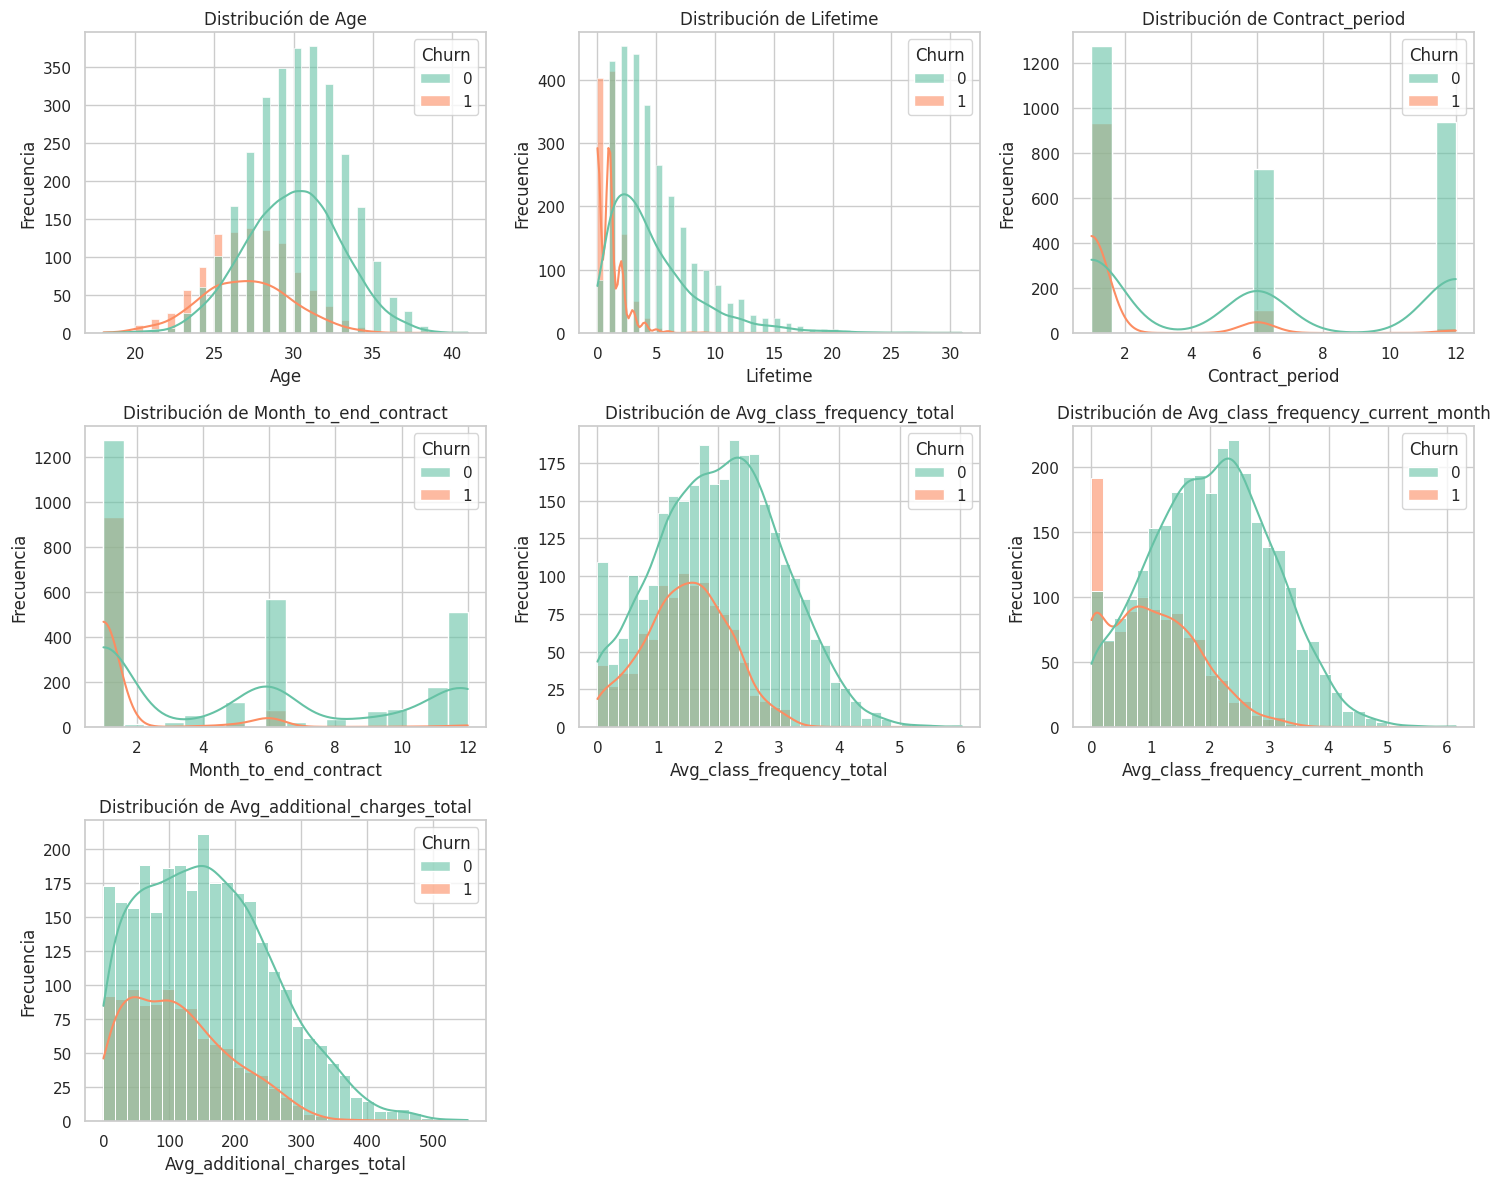

In [23]:
# Ajustes de estilo
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))

# Lista de características numéricas que queremos graficar
features = [
    'Age', 
    'Lifetime',
    'Contract_period',
    'Month_to_end_contract',
    'Avg_class_frequency_total',
    'Avg_class_frequency_current_month',
    'Avg_additional_charges_total'
]

# Graficar cada variable
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, hue='Churn', kde=True, palette='Set2', alpha=0.6)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Paso 3. Construir un modelo para predecir la cancelación de usuarios

Divide los datos en conjuntos de entrenamiento y validación utilizando la función train_test_split().

In [24]:
from sklearn.model_selection import train_test_split

# Variable objetivo
target = df['Churn']

# Variables predictoras (quitamos la columna objetivo)
features = df.drop(columns=['Churn'])

# Dividir datos en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_valid.shape)

Tamaño del conjunto de entrenamiento: (3200, 13)
Tamaño del conjunto de validación: (800, 13)


Divide los datos en conjuntos de entrenamiento y validación utilizando la función train_test_split().
Entrena el modelo en el set de entrenamiento con dos métodos:
regresión logística;
bosque aleatorio.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Modelo 1: Regresión logística
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_valid)

log_acc = accuracy_score(y_valid, y_pred_log)
log_prec = precision_score(y_valid, y_pred_log)
log_recall = recall_score(y_valid, y_pred_log)

# Modelo 2: Bosque aleatorio
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_valid)

rf_acc = accuracy_score(y_valid, y_pred_rf)
rf_prec = precision_score(y_valid, y_pred_rf)
rf_recall = recall_score(y_valid, y_pred_rf)

# Comparación de métricas
results = pd.DataFrame({
    'Modelo': ['Regresión logística', 'Bosque aleatorio'],
    'Exactitud': [log_acc, rf_acc],
    'Precisión': [log_prec, rf_prec],
    'Recall': [log_recall, rf_recall]
})

print(results)


                Modelo  Exactitud  Precisión    Recall
0  Regresión logística    0.92375   0.875622  0.830189
1     Bosque aleatorio    0.92750   0.885000  0.834906


Ambos modelos tuvieron un rendimiento alto y similar, pero el bosque aleatorio tuvo una ligera ventaja en exactitud y precisión, lo que lo hace preferible para este caso.

Estandariza los datos.
Utiliza la función linkage() para crear una matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma. Nota: ¡renderizar el dendrograma puede llevar tiempo! Utiliza el gráfico resultante para estimar el número de clústeres que puedes destacar.

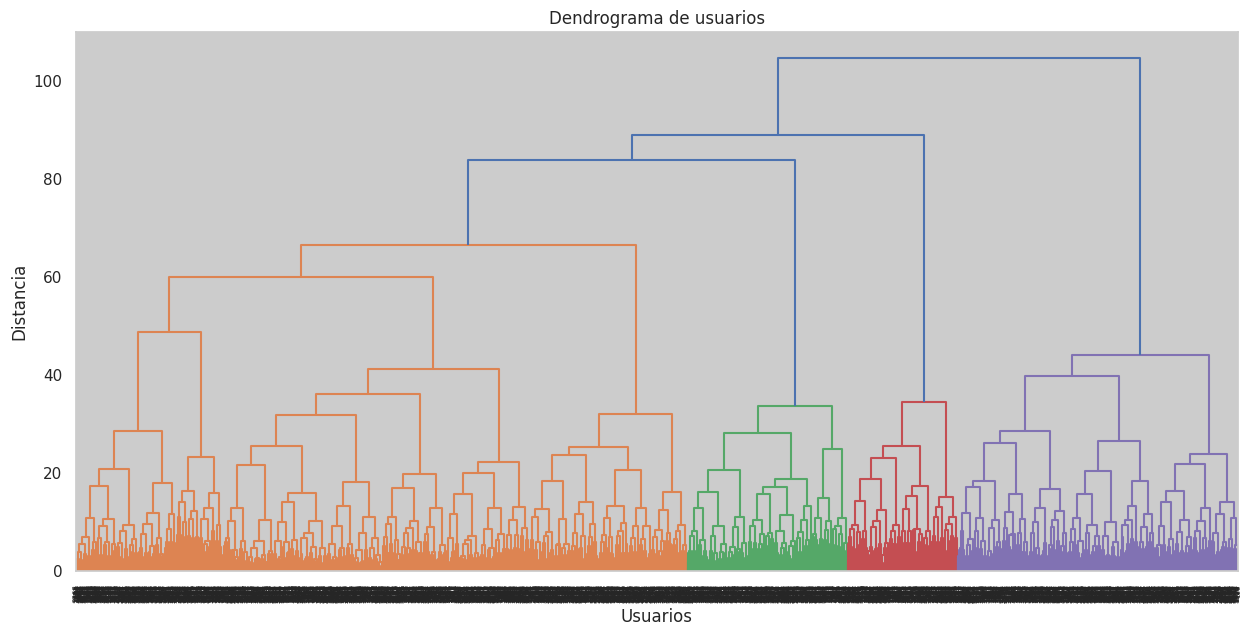

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv('/datasets/gym_churn_us.csv')

# 1. Eliminar la columna objetivo 'Churn'
df_features = df.drop(columns=['Churn'])

# 2. Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

# 3. Crear matriz de distancias con linkage()
linked = linkage(df_scaled, method='ward')

# 4. Graficar el dendrograma
plt.figure(figsize=(15, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Dendrograma de usuarios')
plt.xlabel('Usuarios')
plt.ylabel('Distancia')
plt.show()


Entrena el modelo de clustering con el algortimo K-means y predice los clústeres de clientes. (Deja que el número de clústeres sea n=5 para que sea más sencillo comparar los resultados con los del resto del estudiantado. Sin embargo, en la vida real, nadie te dará tales pistas, así que tendrás que decidir basándote en el gráfico del paso anterior.)

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Eliminamos la columna 'Churn'
df_features = df.drop(columns=['Churn'])

# 2. Estandarizamos los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(df_scaled, columns=df_features.columns)

# 3. Entrenamos K-Means con 5 clústeres
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_scaled)

# 4. Agregamos la columna de clúster al DataFrame original
df['cluster'] = clusters

# 5. Mostramos las primeras filas con el clúster asignado
print(df.head())

# 6. Usuarios por clúster
print(df['cluster'].value_counts())



   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0  

Mira los valores medios de característica para los clústeres.¿Hay algo que te llame la atención?

Si calculamos las medias por clúster, lo que normalmente llama la atención son diferencias claras en edad, duración del contrato, frecuencia de visitas y gasto adicional, porque esos factores suelen estar muy ligados al abandono.

Traza distribuciones de características para los clústeres. ¿Notas algo?
Calcula la tasa de cancelación para cada clúster (utiliza el método groupby()). ¿Difieren en términos de tasa de cancelación? ¿Qué grupos son propensos a irse y cuáles son leales?

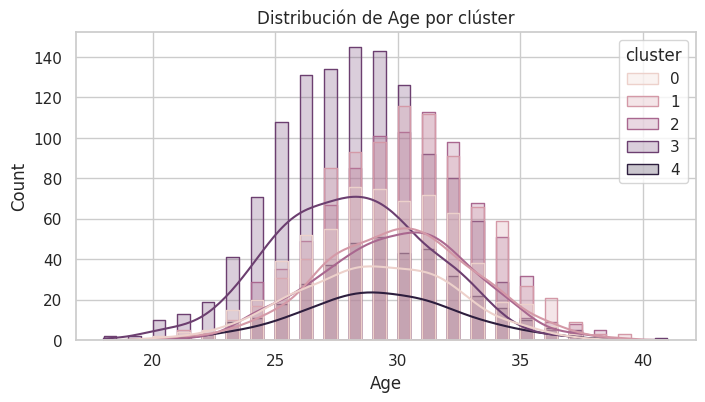

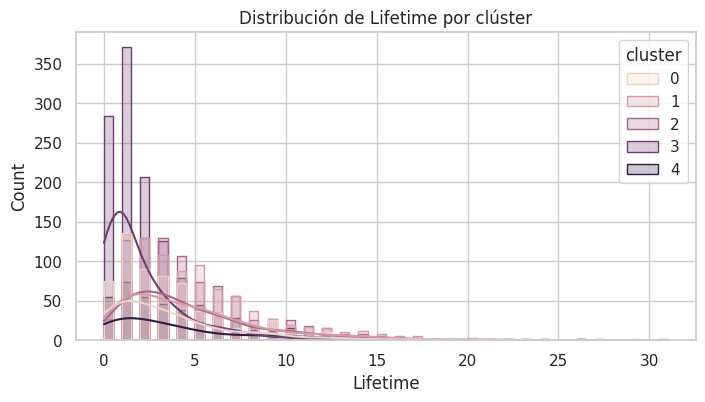

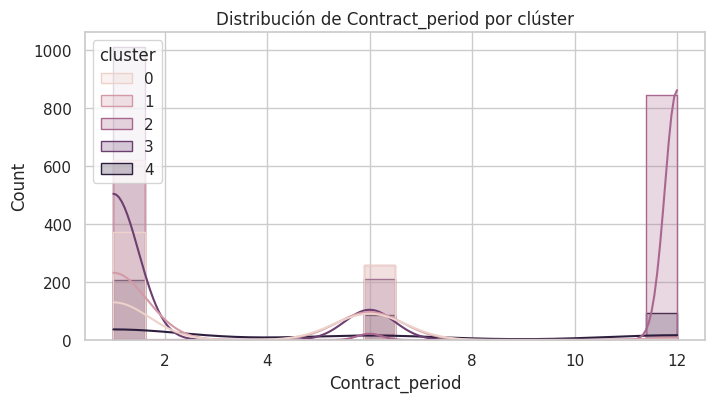

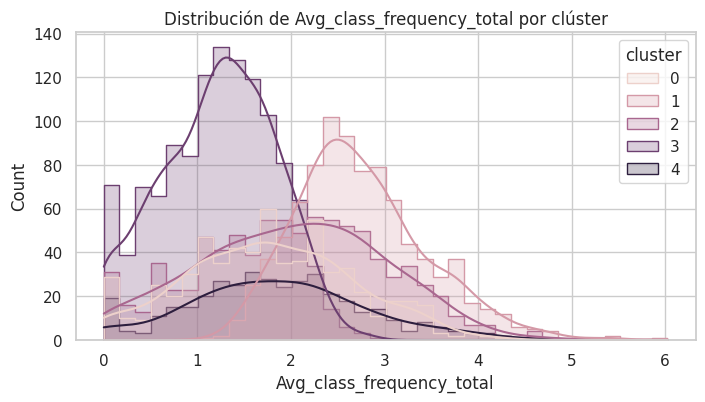

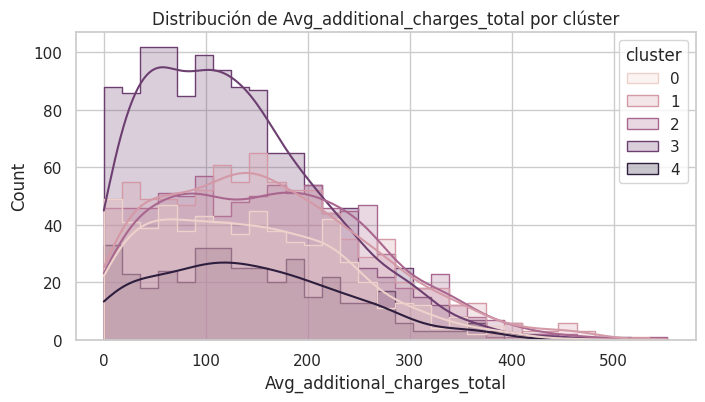

In [28]:
features_to_plot = ['Age', 'Lifetime', 'Contract_period',
                    'Avg_class_frequency_total', 'Avg_additional_charges_total']

for feature in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x=feature, hue='cluster', kde=True, element='step')
    plt.title(f'Distribución de {feature} por clúster')
    plt.show()

Agrupamos por cluster y calculamos el promedio de Churn (como Churn es binaria, el promedio es la tasa de cancelación):

In [29]:
churn_rate_by_cluster = df.groupby('cluster')['Churn'].mean().sort_values(ascending=False)
print(churn_rate_by_cluster)


cluster
3    0.572942
4    0.266839
0    0.246445
1    0.089989
2    0.021965
Name: Churn, dtype: float64


Clúster 3 (57%) → más propensos a cancelar.

Clúster 4 (27%) y 0 (25%) → riesgo medio.

Clúster 1 (9%) y 2 (2%) → clientes muy leales.

En resumen: los grupos 3 y 4 requieren acciones de retención, mientras que 1 y 2 deben recibir estrategias de fidelización.

Aquí tienes un resumen del **Paso 5** con conclusiones y recomendaciones clave:

**Conclusiones**

1. Existe una diferencia clara en la tasa de cancelación entre clústeres: unos son muy leales y otros presentan alto riesgo.
2. El clúster 3 es el más crítico, seguido por el 4; ambos requieren acciones urgentes de retención.
3. Los clústeres 1 y 2 tienen muy baja tasa de cancelación, por lo que son candidatos ideales para programas de fidelización y referidos.

**Recomendaciones**

1. **Retención proactiva para clústeres de alto riesgo** (ej. clúster 3 y 4): ofrecer descuentos personalizados, planes flexibles o membresías trimestrales.
2. **Programas de fidelización para clientes leales** (clúster 1 y 2): beneficios exclusivos, acceso anticipado a clases o eventos VIP.
3. **Campañas de reactivación** para quienes muestran señales tempranas de baja asistencia: mensajes recordatorios, retos de entrenamiento de 30 días.
4. **Segmentación en comunicaciones**: adaptar las campañas de email y push según clúster, enfocando beneficios para leales y retención para los de riesgo.
